In [9]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
from scipy.io import loadmat
import random
import IPython
import yaml

from homtools import get_eigenmike, reduced_eigenmike
from shtools import sound_pressure_from_hoa, get_real_sh
from utils import mystft, multichannel_fft_convolve, trim_signal_to_activity

draw = True  # Whether to plot or not
CONFIG_FILE_PATH = 'config.yaml'
try:
    with open(CONFIG_FILE_PATH, 'r') as file:
        # It's recommended to use yaml.safe_load() for security
        # as yaml.load() can execute arbitrary code.
        config = yaml.safe_load(file)
    print("YAML file loaded successfully!")
    # print(config) # Uncomment to see the full dictionary
except FileNotFoundError:
    print(f"Error: The file {CONFIG_FILE_FILE_PATH} was not found.")
    config = None
except yaml.YAMLError as exc:
    print(f"Error parsing YAML file: {exc}")
    config = None

# Set random seed for reproducibility
random.seed(42)
target_room_id = 1
target_rir_id = 4

# === Paths ===
audio_dir = config['rutas']['audio_dir']
csv_room =  glob.glob(config['rutas']['csv_dir'] + "/room_info_*.csv")[0]
csv_rir =  glob.glob(config['rutas']['csv_dir'] + "/rir_info_*.csv")[0]
srir_dir = config['rutas']['srir_dir']
srir_type = config['rutas']['srir_type']

# User parameters from config file
c = config['general']['c']
fs = config['general']['fs']
winlen = config['general']['winlen']
sh_order = config['hoa_encoding']['sh_order']
Q = (sh_order + 1) ** 2
b_n_len = config['hoa_encoding']['b_n_len']

# Mic angles
hom = get_eigenmike(config['eigenmike']['mic_r'],
                    config['eigenmike']['mic_az'],
                    config['eigenmike']['mic_el'],
                    config['eigenmike']['gain'],
                    config['eigenmike']['w'],
                    isRigid=config['eigenmike']['micType']=='rigid')
# hom = reduced_eigenmike(Q, hom=hom_full)

YAML file loaded successfully!


In [10]:
# # scatter the position of the microphones hom_full and hom
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure(figsize=(6, 6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(hom_full.cart[:, 0], hom_full.cart[:, 1], hom_full.cart[:, 2],
#             color='gray', label='Full Eigenmike')
# ax.scatter(hom.cart[:, 0], hom.cart[:, 1], hom.cart[:, 2],
#             color='red', label=f'Reduced ({Q})')

# ax.set_title("Reduced Eigenmike vs HOA grid")
# ax.set_xlabel("x [m]")
# ax.set_ylabel("y [m]")
# ax.set_zlabel("z [m]")
# ax.legend()
# plt.show()

### Get 5 seconds from a random audio file according to the selected room and rir
Note: Look the signal and pick 5 seconds where the source is active

Current azimuth = 92.55º, elevation = 115.95º


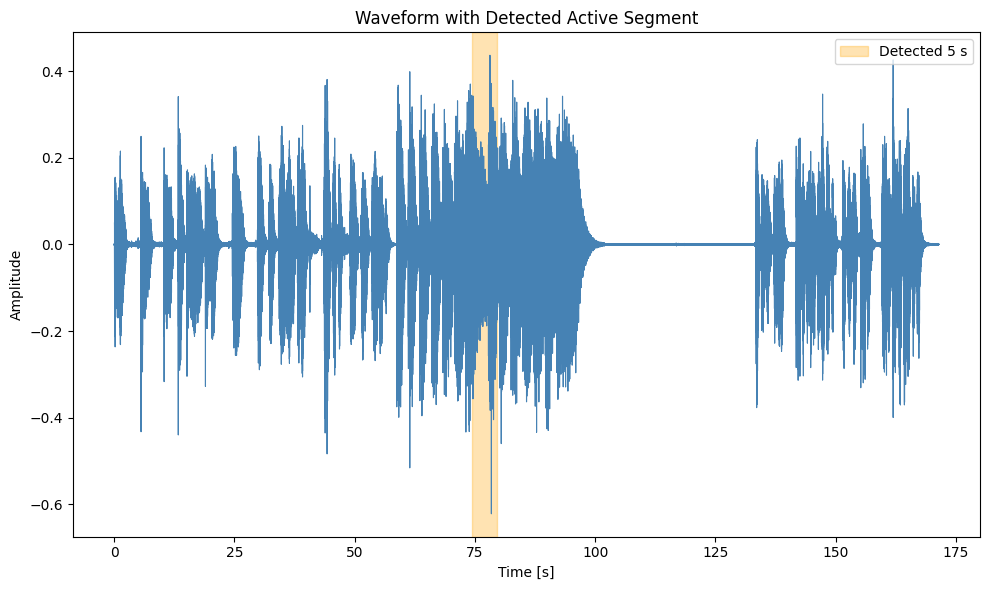

In [11]:
# === List audio folders ===
subfolders = [f for f in os.listdir(audio_dir) if os.path.isdir(os.path.join(audio_dir, f)) and f not in ['.', '..']]
audio_dirs = [os.path.join(audio_dir, folder) for folder in subfolders]

# === Read tables ===
room_info = pd.read_csv(csv_room)
rir_info = pd.read_csv(csv_rir)
rir_list = [f for f in os.listdir(srir_dir) if f.endswith(".mat")]

# Find matching row
row_idx = np.where((rir_info['room_id'] == target_room_id) &
                   (rir_info['rir_id'] == target_rir_id))[0]

if row_idx.size > 0:
    az_deg = np.degrees(rir_info['az'][row_idx])
    el_deg = np.degrees(rir_info['el'][row_idx])
    print(f"Current azimuth = {az_deg._values[0]:.2f}º, elevation = {el_deg._values[0]:.2f}º")
else:
    print("No matching RIR found.")
    
# === Load audio ===
i = 0  # Python is 0-based
song_id = f"train_{i+1}"
vocals_path = os.path.join(audio_dirs[i], 'vocals.wav')
vocals, fs = sf.read(vocals_path)
if vocals.ndim > 1:
    vocals = vocals[:, 0]

valid_start_idx =trim_signal_to_activity(vocals, fs, duration_sec=5, thresh = 0.001)
start_idx = np.random.choice(valid_start_idx)
end_idx = min(start_idx + int(5 * fs), len(vocals))
signal=vocals[start_idx:end_idx]

# === Visualization ===
if draw:
    time = np.arange(len(vocals)) / fs

    # Create figure and axis correctly
    fig, ax = plt.subplots(figsize=(10, 6), sharex=True)

    # Plot waveform
    ax.plot(time, vocals, lw=0.8, color='steelblue')
    ax.axvspan(start_idx / fs, end_idx / fs, color='orange', alpha=0.3, label='Detected 5 s')

    # Labels and title
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Amplitude")
    ax.set_title("Waveform with Detected Active Segment")
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

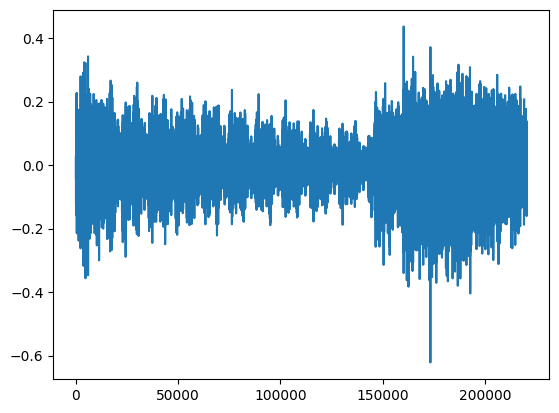

In [12]:
plt.plot(signal)
IPython.display.Audio(signal, rate=fs)

### Estimate the signal in A and B format using the stored RIRs/SRIRs

In [13]:
# === Load RIRs and SRIRs ==
rir_name = f"room{target_room_id}_{target_rir_id}"
if srir_type == 'clean':
    sim_rir=loadmat(os.path.join(srir_dir, f"{rir_name}_clean.mat"))['sim_rir_clean'].astype(np.float64)
    rir_hoa = loadmat(os.path.join(srir_dir, f"hoa_{rir_name}_clean.mat"))['rir_hoa'].astype(np.float64)
else:
    sim_rir=loadmat(os.path.join(srir_dir, f"{rir_name}.mat"))['sim_rir'].astype(np.float64)
    rir_hoa = loadmat(os.path.join(srir_dir, f"hoa_{rir_name}.mat"))['rir_hoa'].astype(np.float64)

# === Simulate multichannel capture ===
if hom.emReference is not None:
    sim_rir = sim_rir[hom.emReference, :]

signal_ref = multichannel_fft_convolve(sim_rir, signal)
signal_hoa = multichannel_fft_convolve(rir_hoa, signal)


### Compute the spherical harmonic signal decomposition using real SH basis functions and get the HOA encoding using the ISFTF

In [14]:
alpha = []
for shc in range(signal_hoa.shape[0]):
    alpha.append(mystft(signal_hoa[shc, :], winlen=winlen))
alpha = np.array(alpha)

### BEAMFORMING TEST

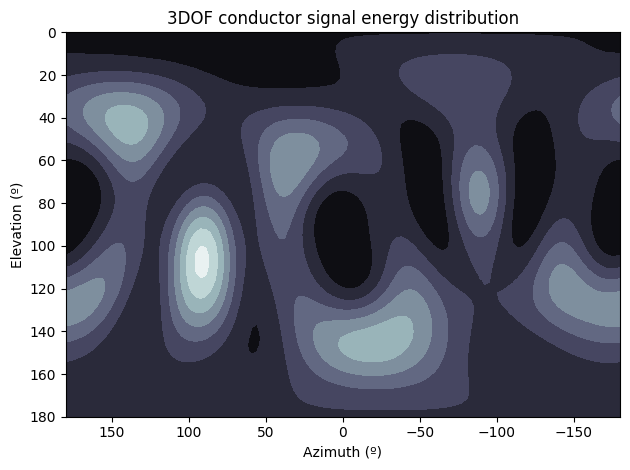

In [15]:
# Beamformer (sin normalizar) a todas las posiciones del espacio
theta,phi = np.linspace(0,np.pi,60), np.linspace(-np.pi,np.pi,120)
theta_mesh,phi_mesh = np.meshgrid(
    theta,
    phi
)

beamformer_order = config['hoa_encoding']['beamformer_order']
Y_l = get_real_sh(beamformer_order, theta_mesh.flatten(), phi_mesh.flatten())
energy = np.apply_along_axis(
    lambda arr: arr@arr/len(arr),
    1,
    Y_l.T @ signal_hoa[:(beamformer_order+1)**2,:]
).real

fig,ax = plt.subplots()
ax.contourf(
    np.degrees(phi_mesh),
    np.degrees(theta_mesh),
    np.reshape(energy,phi_mesh.shape),
    cmap='bone'
)
ax.set_title('3DOF conductor signal energy distribution')
ax.set_xlabel('Azimuth (º)')
ax.set_ylabel('Elevation (º)')
ax.invert_xaxis()
ax.invert_yaxis()
fig.tight_layout()

### Now let's go back from HOA to the original A-format and check the SNR

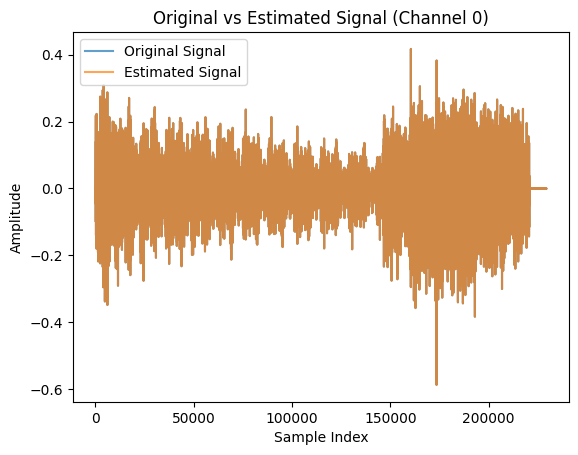

SNR = 81.66 dB


In [16]:
# Spherical harmonics decomposition (STFT of HOA signals)  
signal_est=sound_pressure_from_hoa(signal_hoa, fs, sh_order, hom.r, hom.az, hom.el, hom.isRigid, b_n_len)
# Compenso el retardo de las dos convoluciones 2048 muestras
signal_est = signal_est[:,b_n_len:]

# Ensure both signals are the same length and shape
min_len = min(signal_ref.shape[1], signal_est.shape[1])
signal_orig = signal_ref[:, :min_len]
signal_est = signal_est[:, :min_len]

# Compute noise
noise = signal_ref - signal_est

# Compute SNR in dB
snr_value = 10 * np.log10(np.sum(signal_ref**2) / np.sum(noise**2))

# Print both signals signal_est and signal_orig overlapped plot
plt.figure()
plt.plot(signal_ref[0, :], label='Original Signal', alpha=0.7)
plt.plot(signal_est[0, :], label='Estimated Signal', alpha=0.7)
plt.title('Original vs Estimated Signal (Channel 0)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

IPython.display.display(IPython.display.Audio(signal_est[0, :], rate=fs))
IPython.display.display(IPython.display.Audio(signal_orig[0, :], rate=fs))

print(f"SNR = {snr_value:.2f} dB")